# This notebook was inspired by an AQR paper on value and momentum strategies: https://www.aqr.com/Insights/Research/Journal-Article/The-Interaction-of-Value-and-Momentum-Strategies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import datetime
import json
import statsmodels.api as sm
import math

In [2]:
assets_df = pd.read_csv('data/assets_data.csv')
assets_df.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


In [9]:
symbols = []
cols = assets_df.columns
for col in cols:
    if 'Adj Close' not in col:
        break
    else:
        symbols.append(col.split(': ')[1])


In [14]:
assets_df.groupby(['Year','Month']).groups.keys()

dict_keys([(2009, 12), (2010, 1), (2010, 2), (2010, 3), (2010, 4), (2010, 5), (2010, 6), (2010, 7), (2010, 8), (2010, 9), (2010, 10), (2010, 11), (2010, 12), (2011, 1), (2011, 2), (2011, 3), (2011, 4), (2011, 5), (2011, 6), (2011, 7), (2011, 8), (2011, 9), (2011, 10), (2011, 11), (2011, 12), (2012, 1), (2012, 2), (2012, 3), (2012, 4), (2012, 5), (2012, 6), (2012, 7), (2012, 8), (2012, 9), (2012, 10), (2012, 11), (2012, 12), (2013, 1), (2013, 2), (2013, 3), (2013, 4), (2013, 5), (2013, 6), (2013, 7), (2013, 8), (2013, 9), (2013, 10), (2013, 11), (2013, 12), (2014, 1), (2014, 2), (2014, 3), (2014, 4), (2014, 5), (2014, 6), (2014, 7), (2014, 8), (2014, 9), (2014, 10), (2014, 11), (2014, 12), (2015, 1), (2015, 2), (2015, 3), (2015, 4), (2015, 5), (2015, 6), (2015, 7), (2015, 8), (2015, 9), (2015, 10), (2015, 11), (2015, 12), (2016, 1), (2016, 2), (2016, 3), (2016, 4), (2016, 5), (2016, 6), (2016, 7), (2016, 8), (2016, 9), (2016, 10), (2016, 11), (2016, 12), (2017, 1), (2017, 2), (2017, 3),

In [16]:
cats = []
for col in cols:
    split = col.split(': ')
    if split[0] not in cats:
        cats.append(split[0])
print(cats)

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Month', 'Day', 'Year', 'Date']


In [36]:
def return_quintile_list(l):
    #l is numeric, unordered list
    new_l = l[:]
    argsort = np.argsort(np.array(l))
    new_l.sort()
    length = len(new_l)
    mod = length % 5
    quintile_base_sz = math.floor(length/5)
    quintiles = []
    idx_quintiles = []
    i = 0
    start_idx = 0
    while i < 5:
        if mod != 0:
            add = quintile_base_sz+1
            mod-=1
        else:
            add = quintile_base_sz
        quintiles.append(new_l[start_idx:start_idx+add])
        idx_quintiles.append(argsort[start_idx:start_idx+add])
        start_idx+=add
        i+=1
    return quintiles, idx_quintiles

In [37]:
return_quintile_list([1,2,3,4,5,6,7,8,9,10])

([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]],
 [array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8, 9])])

In [40]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(6,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 6

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/6)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)
        
        
    

In [42]:
(q1_ret == q2_ret)  == (q2_ret == q3_ret) == (q3_ret == q4_ret) == (q4_ret == q5_ret)

True

# In the plot below, quintiles are formed based on the average monthly returns over the preceding 6 months; from these quintiles, equal weighted portfolios are constructed and the portfolio's next monthly return is plotted

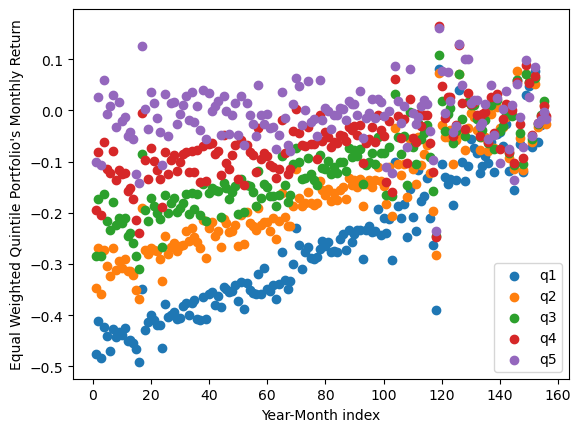

In [45]:
x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

# Repeat above analysis with lookback period of 12 months instead of 6 months

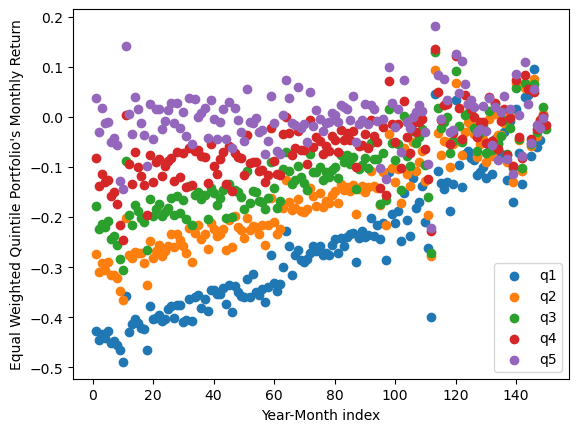

In [47]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(12,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 12

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/12)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

# Repeat above analysis with lookback period of 1 month instead of 6 months

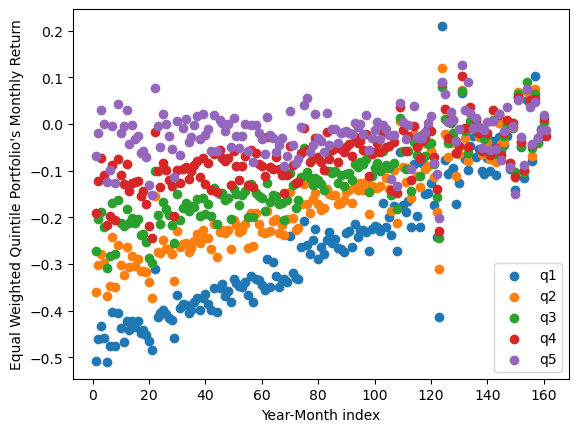

In [56]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(1,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 1

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/1)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

# Repeat above analysis with lookback period of 3 months instead of 1 year

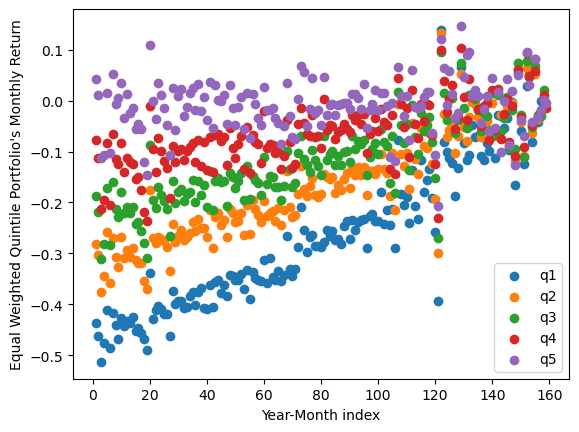

In [48]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(3,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 3

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/3)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

# Repeat above analysis with lookback period of 6 months, excluding most recent month

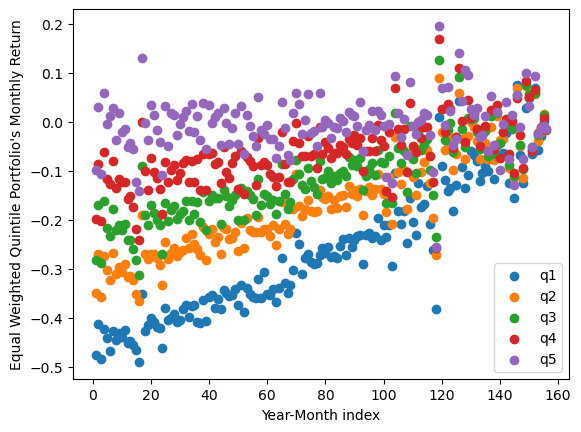

In [50]:
lookback_months = 6
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

# Repeat above analysis with lookback period of 12 months, excluding most recent month

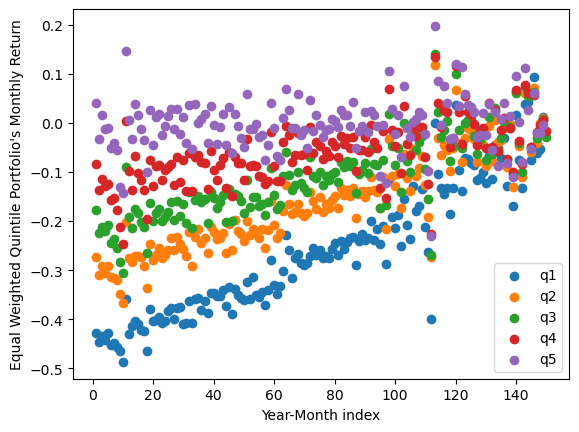

In [51]:
lookback_months = 12
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

# Repeat above analysis with lookback period of 3 months, excluding most recent month

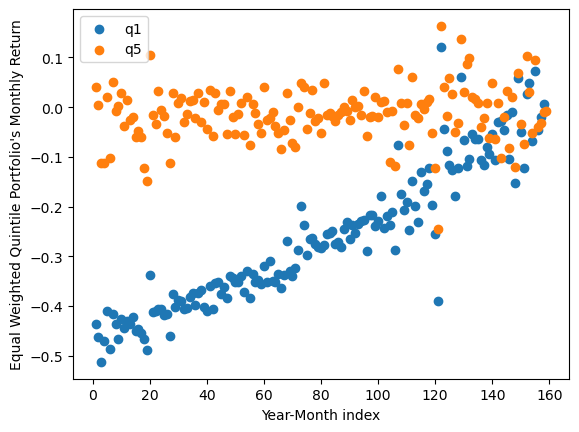

In [57]:
lookback_months = 3
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
#plt.scatter(x,q2_ret,label='q2')
#plt.scatter(x,q3_ret,label='q3')
#plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

# The support for momentum seems to be dimin irregardless of the lookback period we use. In addition, if look at the more recent months, the returns of the q1 and. q5 portfolios are hard to distinguish

# We can repeat a similar analysis while controlling for beta

In [60]:
with open('data/monthly_beta.json', 'r') as fp:
    monthly_beta_dict = json.load(fp)
for key in monthly_beta_dict.keys():
    for key1 in monthly_beta_dict[key].keys():
        for key2 in monthly_beta_dict[key][key1].keys():
            print(key,key1,key2,sep=', ')

2011, 1, WPM
2011, 1, NNI
2011, 1, MET
2011, 1, MMP
2011, 1, ATR
2011, 1, HI
2011, 1, BR
2011, 1, GTLS
2011, 1, JHX
2011, 1, SNV
2011, 1, HD
2011, 1, LMT
2011, 1, T
2011, 1, SKX
2011, 1, FHI
2011, 1, DAL
2011, 1, CNP
2011, 1, CAT
2011, 1, VFC
2011, 1, KMB
2011, 1, BXP
2011, 1, HR
2011, 1, MTB
2011, 1, JBL
2011, 1, WTM
2011, 1, SEE
2011, 1, UHAL
2011, 1, RBC
2011, 1, TJX
2011, 1, ASGN
2011, 1, RNR
2011, 1, NSC
2011, 1, GGB
2011, 1, INFY
2011, 1, CLF
2011, 1, L
2011, 1, DCP
2011, 1, AMP
2011, 1, OI
2011, 1, LHX
2011, 1, PUK
2011, 1, EFX
2011, 1, DOV
2011, 1, PFE
2011, 1, RTX
2011, 1, AIG
2011, 1, LNC
2011, 1, UGI
2011, 1, BAC
2011, 1, SYY
2011, 1, FCX
2011, 1, HRL
2011, 1, ARW
2011, 1, BP
2011, 1, DVN
2011, 1, F
2011, 1, PAG
2011, 1, EQNR
2011, 1, FRO
2011, 1, ELS
2011, 1, SHEL
2011, 1, DUK
2011, 1, APH
2011, 1, PSO
2011, 1, DHR
2011, 1, ASR
2011, 1, FLR
2011, 1, CCJ
2011, 1, ENLC
2011, 1, TTE
2011, 1, AEG
2011, 1, AEE
2011, 1, TPX
2011, 1, CBT
2011, 1, MCK
2011, 1, CSL
2011, 1, KWR
2011

2016, 2, PBR
2016, 2, DDS
2016, 2, FNF
2016, 2, MMC
2016, 2, MHK
2016, 2, BLDR
2016, 2, KT
2016, 2, TRTN
2016, 2, HEI
2016, 2, ALK
2016, 2, SUZ
2016, 2, UNM
2016, 2, PB
2016, 2, GFI
2016, 2, SF
2016, 2, D
2016, 2, JEF
2016, 2, ROP
2016, 2, RCL
2016, 2, ACN
2016, 2, PSA
2016, 2, MFG
2016, 2, VTR
2016, 2, BC
2016, 2, TFC
2016, 2, TSM
2016, 2, BDC
2016, 2, WM
2016, 2, KIM
2016, 2, NCR
2016, 2, POR
2016, 2, SNN
2016, 2, SCCO
2016, 2, GIB
2016, 2, DIS
2016, 2, RBA
2016, 2, ADM
2016, 2, MLM
2016, 2, LVS
2016, 2, AMT
2016, 2, LIN
2016, 2, CF
2016, 2, PII
2016, 2, FUL
2016, 2, TFX
2016, 2, AEM
2016, 2, NWG
2016, 2, HMC
2016, 2, MPW
2016, 2, WCC
2016, 2, TTC
2016, 2, MSA
2016, 2, RJF
2016, 2, WPP
2016, 2, IHG
2016, 2, WFG
2016, 2, COP
2016, 2, FIX
2016, 2, HSBC
2016, 2, ING
2016, 2, BAK
2016, 2, AVA
2016, 2, HRB
2016, 2, DINO
2016, 2, NEM
2016, 2, RHP
2016, 2, PKX
2016, 2, TRI
2016, 2, ITUB
2016, 2, PNR
2016, 2, KEP
2016, 2, MLI
2016, 2, CM
2016, 2, ERF
2016, 2, PPG
2016, 2, FNV
2016, 2, INGR
2

2020, 5, H
2020, 5, OLN
2020, 5, STM
2020, 5, CW
2020, 5, KOF
2020, 5, WSM
2020, 5, NUE
2020, 5, NMR
2020, 5, OC
2020, 5, CRH
2020, 5, TDG
2020, 5, TYL
2020, 5, GPI
2020, 5, BSAC
2020, 5, NVO
2020, 5, WDS
2020, 5, DHI
2020, 5, BEN
2020, 5, RDN
2020, 5, SID
2020, 5, MKL
2020, 5, SIG
2020, 5, PLD
2020, 5, RS
2020, 5, VALE
2020, 5, TLK
2020, 5, STZ
2020, 5, PEAK
2020, 5, CCL
2020, 5, WPC
2020, 5, SBS
2020, 5, GE
2020, 5, AEL
2020, 5, EBR
2020, 5, SHW
2020, 5, MRO
2020, 5, IP
2020, 5, MT
2020, 5, STE
2020, 5, MTD
2020, 5, MA
2020, 5, UPS
2020, 5, WFC
2020, 5, CWT
2020, 5, BSBR
2020, 5, BBVA
2020, 5, CPG
2020, 5, BBWI
2020, 5, ES
2020, 5, TGT
2020, 5, EPD
2020, 5, BCH
2020, 5, LUV
2020, 5, PKI
2020, 5, AMG
2020, 5, KNX
2020, 5, UNF
2020, 5, PCG
2020, 5, ROL
2020, 5, NOK
2020, 5, KR
2020, 5, VMW
2020, 5, MAIN
2020, 5, IDA
2020, 5, SKY
2020, 5, MDC
2020, 5, ORCL
2020, 5, SLB
2020, 5, RY
2020, 5, DECK
2020, 5, SUI
2020, 5, ABG
2020, 5, BMO
2020, 5, MS
2020, 5, NEU
2020, 5, SON
2020, 5, IBN
202

2022, 8, RY
2022, 8, DECK
2022, 8, SUI
2022, 8, ABG
2022, 8, BMO
2022, 8, MS
2022, 8, NEU
2022, 8, SON
2022, 8, IBN
2022, 8, FMX
2022, 8, BKH
2022, 8, TX
2022, 8, MODG
2022, 8, EPR
2022, 8, GIL
2022, 8, FE
2022, 8, BUD
2022, 8, VSH
2022, 8, WOLF
2022, 8, MFC
2022, 8, AWK
2022, 8, X
2022, 8, HL
2022, 8, PAAS
2022, 8, CB
2022, 8, WLK
2022, 8, EDU
2022, 8, WU
2022, 8, KRG
2022, 8, CNA
2022, 8, FSS
2022, 8, TFII
2022, 8, SPXC
2022, 8, ENOV
2022, 8, MMM
2022, 8, ABT
2022, 8, ORA
2022, 8, BK
2022, 8, LAC
2022, 8, IFF
2022, 8, BBY
2022, 8, HES
2022, 8, TS
2022, 8, AVY
2022, 8, CPB
2022, 8, CHT
2022, 8, CFR
2022, 8, WRB
2022, 8, AAP
2022, 8, VLO
2022, 8, ETN
2022, 8, AN
2022, 8, SKM
2022, 8, WCN
2022, 8, ITW
2022, 8, CMI
2022, 8, EC
2022, 8, CVE
2022, 8, BWA
2022, 8, AYI
2022, 8, GWW
2022, 8, NNN
2022, 8, DD
2022, 8, WELL
2022, 8, MAS
2022, 8, FNB
2022, 8, KO
2022, 8, THO
2022, 8, PHG
2022, 8, ABEV
2022, 8, MAN
2022, 8, BN
2022, 8, CPT
2022, 8, NYT
2022, 8, SCI
2022, 8, MOH
2022, 8, ECL
2022, 

In [61]:
def get_lowest_and_upper_quintile_beta(bdict,month,year, s):
    symbols_to_beta_dict = bdict[str(year)][str(month)]
    symbols = s
    beta_list = []
    for sym in symbols:
        beta_list.append(symbols_to_beta_dict[sym])
    quintiles, index_quintiles = return_quintile_list(beta_list)
    equity_quintiles = []
    for q in range(5):
        cur_q = index_quintiles[q]
        l = []
        for idx in cur_q:
            l.append(symbols[idx])
        equity_quintiles.append(l[:])
    return equity_quintiles

In [64]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
lookback = 6

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret_lb = []
q2_ret_lb = []
q3_ret_lb = []
q4_ret_lb = []
q5_ret_lb = []

q1_ret_hb = []
q2_ret_hb = []
q3_ret_hb = []
q4_ret_hb = []
q5_ret_hb = []

for year in range(2011,2024):
    end_month = 13
    if year == 2023:
        end_month = 1
    for month in range(1,end_month):
        #loop thru months and years
        
        #retrieve lowest quintile and highest quintile stocks wrt beta for month/year at hand
        stock_quintiles = get_lowest_and_upper_quintile_beta(monthly_beta_dict,month,year,symbols)
        low_beta = stock_quintiles[0]
        high_beta = stock_quintiles[4]
        
        
        lb_six_month_rets = []
        hb_six_month_rets = []
        key_it = keys.index((year,month))
        
        #append for each stock, average monthly return over lookback months period
        for s in low_beta:
            lb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        for s in high_beta:
            hb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        
        
        #get quintiles for low and high beta past lookback months' average monthly returns 
        lb_quintiles, lb_idx_quintiles = return_quintile_list(lb_six_month_rets)
        hb_quintiles, hb_idx_quintiles = return_quintile_list(hb_six_month_rets)
        
        for q in range(5):
            
            #for low beta companies, for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
            #each of those companies, find the monthly return for the current month, year combination and
            #average it over the quintile

            lb_equities = [] #will contain companies belonging to qth quintile of low beta stocks
            for element in lb_idx_quintiles[q]:
                lb_equities.append(low_beta[element])
            
            hb_equities = []
            for element in hb_idx_quintiles[q]:
                hb_equities.append(high_beta[element])

            lb_ret_sum = 0
            for company in lb_equities:
                lb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            lb_avg_ret = lb_ret_sum/len(lb_equities)
            
            hb_ret_sum = 0
            for company in hb_equities:
                hb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            hb_avg_ret = hb_ret_sum/len(hb_equities)
            
            
            if q == 0:
                q1_ret_lb.append(lb_avg_ret)
                q1_ret_hb.append(hb_avg_ret)
            elif q==1:
                q2_ret_lb.append(lb_avg_ret)
                q2_ret_hb.append(hb_avg_ret)
            elif q==2:
                q3_ret_lb.append(lb_avg_ret)
                q3_ret_hb.append(hb_avg_ret)
            elif q==3:
                q4_ret_lb.append(lb_avg_ret)
                q4_ret_hb.append(hb_avg_ret)
            else:
                q5_ret_lb.append(lb_avg_ret)
                q5_ret_hb.append(hb_avg_ret)


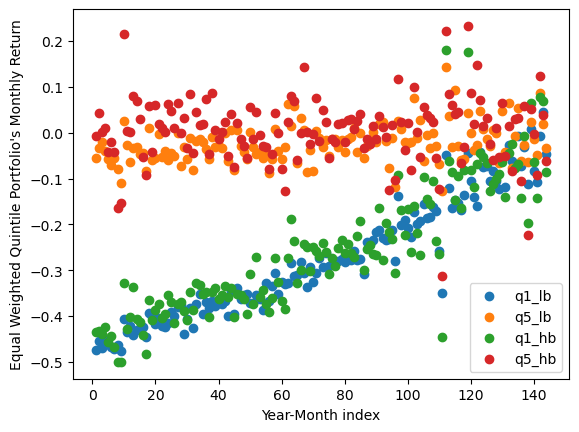

In [65]:
x = np.arange(1,len(q1_ret_lb)+1)
plt.scatter(x,q1_ret_lb,label='q1_lb')
plt.scatter(x,q5_ret_lb,label='q5_lb')
plt.scatter(x,q1_ret_hb,label='q1_hb')
plt.scatter(x,q5_ret_hb,label='q5_hb')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        